In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from utils_datetime import *
from utils_filter import *
from sklearn.calibration import calibration_curve

In [76]:
#binary_reports = True
#if binary_reports:
#    bin_string = 'binary_'
#else:
#    bin_string = ''


contingency_type = 'optimal_' # '' for outlook vs pph, 'binary_' for optimal vs reports, 'optimal_' for pph vs outlooks

In [77]:
#if binary_reports:
#    pph = xr.open_dataset('data/storm_reports/grid_reports.nc')
#    pph_dummy = xr.open_dataset('data/pph/labelled_pph.nc')
#else:
#    pph = xr.open_dataset('data/pph/labelled_pph.nc')
#grid_outlooks = xr.load_dataset('~/Downloads/grid_outlooks.nc')

if contingency_type == '':
    forecast = xr.open_dataset('~/Downloads/grid_outlooks.nc')
    verification = xr.open_dataset('data/pph/labelled_pph.nc')
    pph = verification.copy()

elif contingency_type == 'binary_':
    forecast = xr.open_dataset('~/Downloads/grid_outlooks.nc')
    verification = xr.open_dataset('data/storm_reports/grid_reports.nc')
    pph = xr.open_dataset('data/pph/labelled_pph.nc')

else: # optimal
    forecast = xr.open_dataset('data/pph/labelled_pph.nc')
    verification = xr.open_dataset('data/storm_reports/grid_reports.nc')
    pph = forecast.copy()

In [78]:
missing_dates = ['200204250000', '200208300000', '200304150000', '200304160000', '200306250000', '200307270000', '200307280000', '200312280000', '200404140000', '200408090000', '200905280000', '201105210000', '202005240000']
pph = pph.sel(time=~pph['time'].isin(missing_dates))
forecast = forecast.sel(time=~forecast['time'].isin(missing_dates))
verification = verification.sel(time=~verification['time'].isin(missing_dates))

day3_dates = pph['time'][pph['time'] >= '200203300000']
pph = pph.sel(time = day3_dates)
forecast = forecast.sel(time = day3_dates)
verification = verification.sel(time = day3_dates)

mdt_dates = pph['time'][pph['MAX_CAT'].isin(['MDT', 'HIGH'])]

mdt_pph = pph.sel(time = mdt_dates)
mdt_forecast = forecast.sel(time = mdt_dates)
mdt_verificaiton = verification.sel(time = mdt_dates)

In [79]:
mod = True
if mod:
    curr_forecast = mdt_forecast
    curr_verification = mdt_verificaiton
else:
    curr_forecast = forecast
    curr_verification = verification

In [80]:
outlook_key_dict = {
    'Wind': 'Day 1 Wind',
    'Hail': 'Day 1 Hail',
    'Tornado': 'Day 1 Tornado',
    'All Hazard': 'Day 1'
}
pph_key_dict = {
    'Wind': 'p_perfect_wind',
    'Hail': 'p_perfect_hail',
    'Tornado': 'p_perfect_tor',
    'All Hazard': 'p_perfect_totalsvr'
}
reports_key_dict = {
    'Wind': 'Wind',
    'Hail': 'Hail',
    'Tornado': 'Tornado',
    'All Hazard': 'Total Reports'
}

time_periods = ['2002_2006', '2007_2011', '2012_2016', '2017_2023']

hazards = ['Wind', 'Hail', 'Tornado', 'All Hazard']

In [89]:
def make_calibration_curve(verification_probs, forecast_probs, title, labels, colors, show = True, save = False, save_title = None, counts = False):
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    
    
    plt.xlabel('Outlook Probability')
    if save_title[0:6] == 'binary':
        plt.ylabel('Observed Probability')
    else:
        plt.ylabel('PPH Probability')
    plt.title(title)

    m = 0
    
    for i, (verification_prob, forecast_prob) in enumerate(zip(verification_probs, forecast_probs)):
        flat_forecast = forecast_prob.values.flatten()

        if contingency_type == 'optimal_':
            flat_forecast = flat_forecast.round(1)

        flat_verification = verification_prob.values.flatten()

        # Find the unique predicted values and the indices for grouping
        unique_vals, inverse_indices = np.unique(flat_forecast, return_inverse=True)

        # Compute the sum and count for each unique predicted value
        sum_verification = np.bincount(inverse_indices, weights=flat_verification)
        count_verification = np.bincount(inverse_indices)

        # Calculate the mean verification_prob for each unique forecast probability
        mean_verification = sum_verification / count_verification

        # Plot the calibration curve: x-axis: unique predicted values; y-axis: mean verification_prob
        print(unique_vals, mean_verification)
        
        plt.plot(unique_vals, mean_verification, marker='o', linestyle='-', label = labels[i], color = colors[i])
        
        if max(max(unique_vals), max(mean_verification)) > m:
            m = max(max(unique_vals), max(mean_verification))

        if counts:
            for i, count in enumerate(count_verification):
                if i == 0:
                    plt.annotate(count, (unique_vals[i]+.01, mean_verification[i]+.01))
                else:
                    plt.annotate(count, (unique_vals[i]+.01, mean_verification[i]-.01))

    #print(mean_verification[0])

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()   
    
    if save:
        plt.savefig('plots/calibration/' + save_title + '.pdf')
    if show: 
        plt.show()
    

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ] [1.48908448e-05 4.18316277e-02 1.44991699e-01 2.92675259e-01
 4.82880161e-01 6.58982512e-01 7.90669856e-01 8.56854839e-01
 9.30147059e-01 9.64028777e-01 8.97959184e-01]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ] [0.         0.03504571 0.12463415 0.27498033 0.45790081 0.65058236
 0.76470588 0.84901961 0.89795918 0.95180723 0.98275862]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ] [0.         0.03596099 0.12597276 0.26503165 0.45545657 0.61633282
 0.79104478 0.89189189 0.92708333 0.97435897 1.        ]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ] [0.         0.03043478 0.10144928 0.25624422 0.43048128 0.61928934
 0.78586724 0.85082873 0.93469388 0.95283019 1.        ]


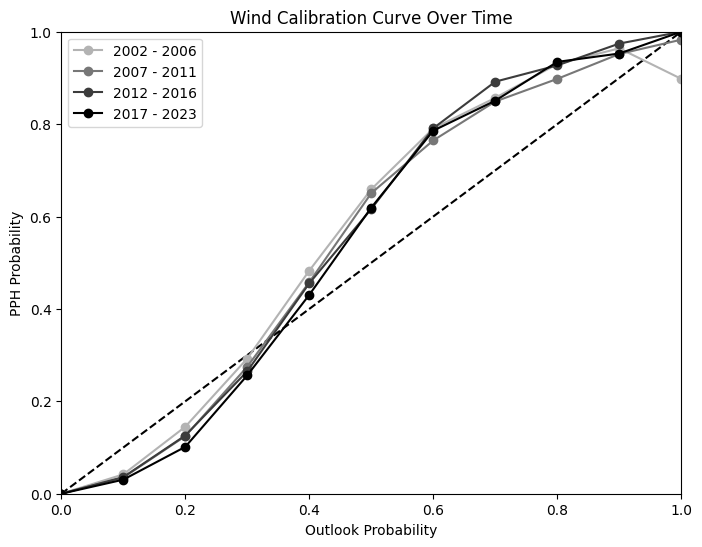

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ] [6.61986110e-06 3.75597396e-02 1.30280360e-01 2.77887952e-01
 4.62914648e-01 6.42432432e-01 7.82026015e-01 8.60082305e-01
 9.21236291e-01 9.59100204e-01 9.51219512e-01]


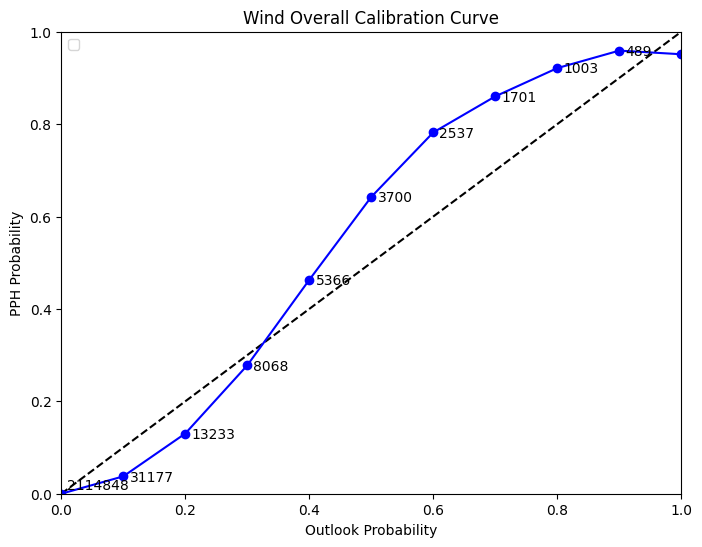

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ] [1.47856191e-05 4.80215827e-02 1.65306598e-01 3.39991316e-01
 5.30434783e-01 6.96887686e-01 7.71771772e-01 8.38095238e-01
 9.02439024e-01 9.13043478e-01 1.00000000e+00]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8] [0.         0.04016573 0.17101205 0.31708623 0.50437828 0.68032787
 0.80350877 0.81818182 0.89189189]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9] [0.         0.03765096 0.16769837 0.31443299 0.54032258 0.71717172
 0.81651376 0.82608696 0.90909091 1.        ]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9] [0.         0.04325371 0.15309446 0.3338301  0.50128535 0.63675214
 0.78571429 0.74074074 0.9375     0.75      ]


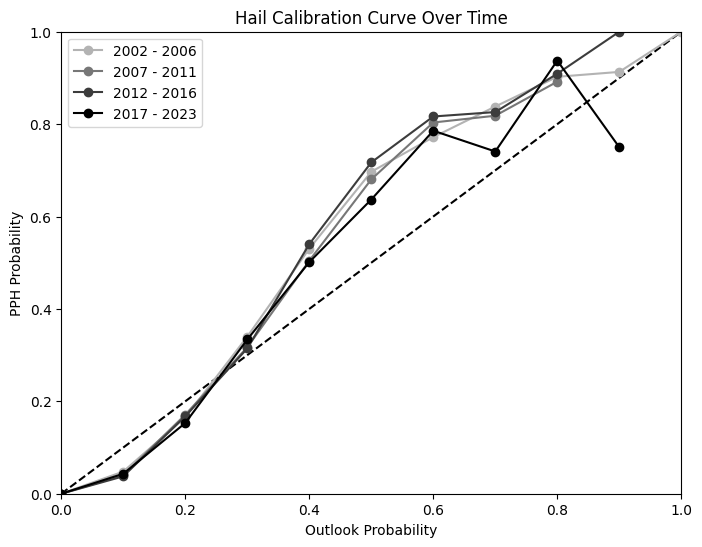

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ] [6.56764534e-06 4.33468485e-02 1.66190958e-01 3.27654448e-01
 5.20532427e-01 6.87234043e-01 7.90080738e-01 8.13218391e-01
 9.05172414e-01 9.21052632e-01 1.00000000e+00]


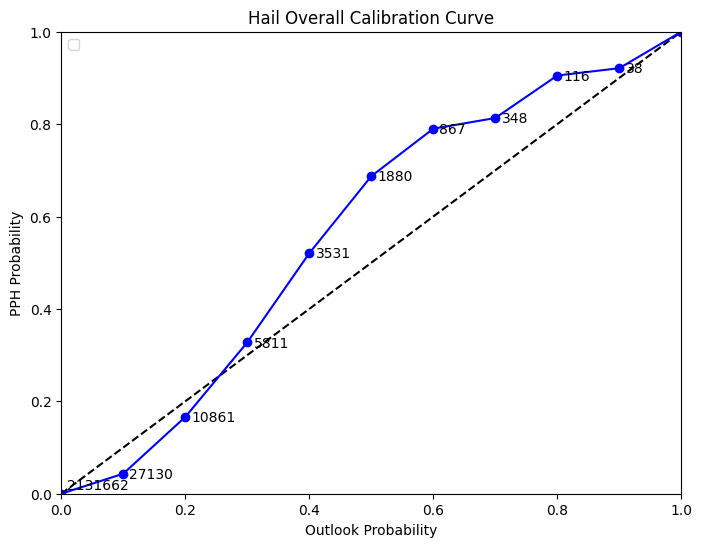

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7] [1.25147048e-05 6.69196275e-02 2.17419777e-01 4.24398625e-01
 5.60483871e-01 7.31092437e-01 8.60000000e-01 1.00000000e+00]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7] [0.         0.05487053 0.18140736 0.38211382 0.58583106 0.70520231
 0.86842105 0.94117647]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8] [3.09703954e-06 5.50341297e-02 2.20246238e-01 4.06976744e-01
 5.14851485e-01 7.74193548e-01 8.28571429e-01 8.88888889e-01
 1.00000000e+00]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7] [3.35013363e-05 5.70995452e-02 1.96185286e-01 3.94520548e-01
 5.70621469e-01 7.34177215e-01 8.12500000e-01 8.46153846e-01]


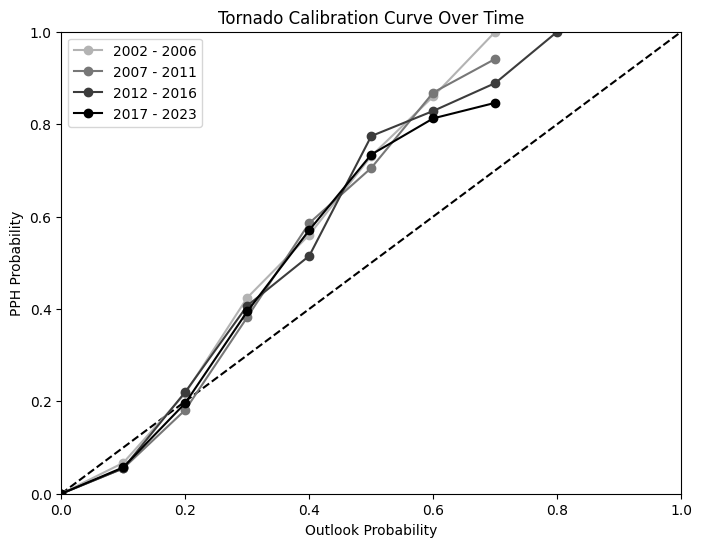

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8] [1.01889070e-05 5.98518716e-02 2.02158115e-01 4.00411734e-01
 5.67749160e-01 7.27482679e-01 8.49740933e-01 9.06976744e-01
 1.00000000e+00]


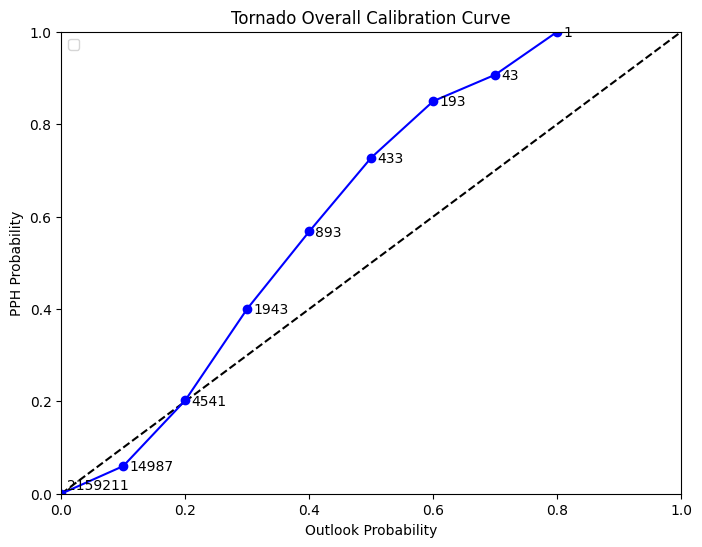

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ] [8.58153640e-06 3.70677555e-02 1.29511362e-01 2.67828107e-01
 4.58585859e-01 6.57844991e-01 7.76906629e-01 8.68131868e-01
 9.02857143e-01 9.59183673e-01 9.76470588e-01]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ] [0.         0.02969555 0.11962653 0.24136868 0.43760908 0.64139942
 0.79147641 0.8458693  0.90106007 0.96307692 0.97938144]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ] [3.19619525e-06 2.87586458e-02 1.19501752e-01 2.43210622e-01
 4.41880342e-01 6.38888889e-01 7.54433834e-01 8.72659176e-01
 9.47019868e-01 9.71631206e-01 1.00000000e+00]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ] [0.         0.02940431 0.10047344 0.22127329 0.39519651 0.60465116
 0.7829233  0.8440367  0.91327913 0.95705521 0.94871795]


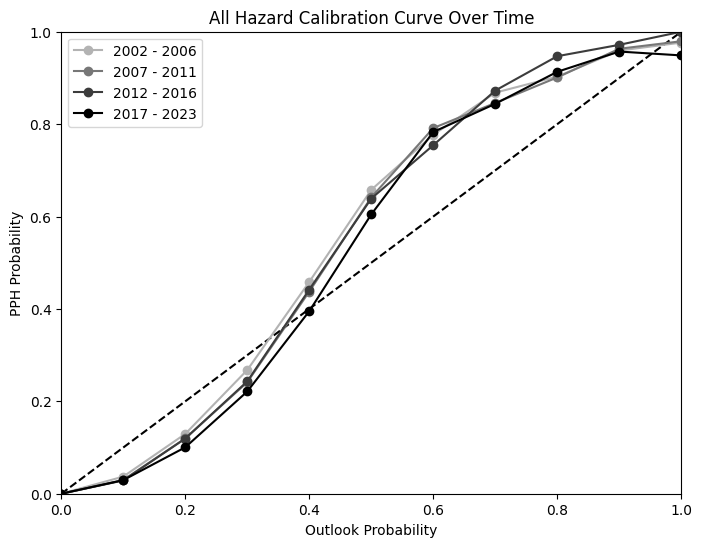

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ] [4.29202970e-06 3.27484073e-02 1.21451297e-01 2.50047646e-01
 4.41480675e-01 6.42122361e-01 7.78555904e-01 8.57857143e-01
 9.12031782e-01 9.62242563e-01 9.75308642e-01]


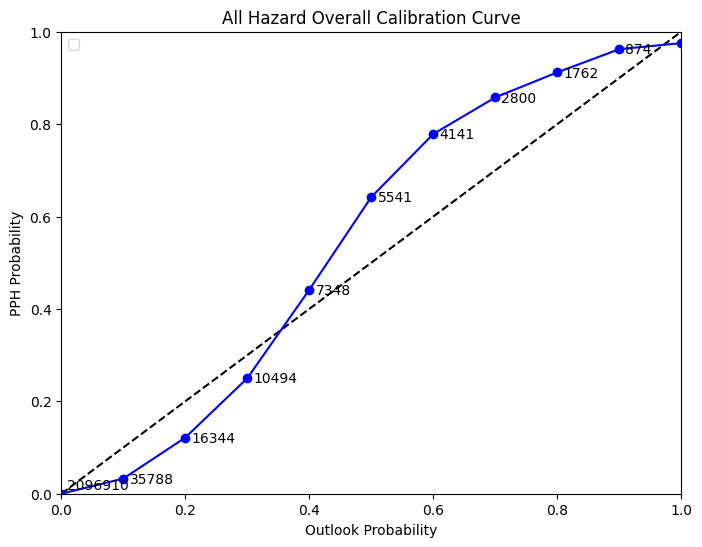

In [90]:
for haz in hazards:
    verification_probs = []
    forecast_probs = []
    labels = []
    colors = []
    greys = np.linspace(.7, 0, len(time_periods))
    for i, time_period in enumerate(time_periods):
        if time_period != 'all':
            year1 = time_period.split('_')[0]
            year2 = time_period.split('_')[1]
            this_verification = curr_verification.sel(time = (curr_verification['time'] >= year1 + '01010000') & (curr_verification['time'] <= year2 + '12312359'))
            this_forecast = curr_forecast.sel(time = (curr_forecast['time'] >= year1 + '01010000') & (curr_forecast['time'] <= year2 + '12312359'))
        else:
            year1 = '2002'
            year2 = '2023'
            this_verification = curr_verification
            this_forecast = curr_forecast

        #if binary_reports:
        #    pph_probs.append(this_pph.sel(hazard = pph_key_dict[haz])['bool'])
        #else:
        #    pph_probs.append(this_pph[pph_key_dict[haz]] / 100)
        #outlook_probs.append(this_outlooks.sel(outlook = outlook_key_dict[haz])['prob'])

        if contingency_type == '':
            verification_probs.append(this_verification[pph_key_dict[haz]] / 100)
            forecast_probs.append(this_forecast.sel(outlook = outlook_key_dict[haz])['prob'])

        elif contingency_type == 'binary_':
            verification_probs.append(this_verification.sel(hazard = reports_key_dict[haz])['bool'])
            forecast_probs.append(this_forecast.sel(outlook = outlook_key_dict[haz])['prob'])

        else: #optimal:
            verification_probs.append(this_verification.sel(hazard = reports_key_dict[haz])['bool'])
            forecast_probs.append(this_forecast[pph_key_dict[haz]] / 100)

        labels.append(year1 + ' - ' + year2)
        colors.append(str(greys[i]))
    #print(verification_probs.values(), forecast_probs.values())
    make_calibration_curve(verification_probs, forecast_probs, haz + ' Calibration Curve Over Time', labels, colors, save = True, save_title = (contingency_type + 'calibration_curve_' + haz + '_over_time' + ('_mdt' if mod else '_all')))

    #if binary_reports:
    #    overall_pph = curr_pph.sel(hazard = pph_key_dict[haz])['bool']
    #else:
    #    overall_pph = curr_pph[pph_key_dict[haz]] / 100

    if contingency_type == '':
        overall_verification = [curr_verification[pph_key_dict[haz]] / 100]
        overall_forecast = [curr_forecast.sel(outlook = outlook_key_dict[haz])['prob']]

    elif contingency_type == 'binary_':
        overall_verification = [curr_verification.sel(hazard = reports_key_dict[haz])['bool']]
        overall_forecast = [curr_forecast.sel(outlook = outlook_key_dict[haz])['prob']]

    else: #optimal:
        overall_verification = [curr_verification.sel(hazard = reports_key_dict[haz])['bool']]
        overall_forecast = [curr_forecast[pph_key_dict[haz]] / 100]

    
    make_calibration_curve(overall_verification, overall_forecast, haz + ' Overall Calibration Curve', [None], ['blue'], save = True, save_title = (contingency_type + 'calibration_curve_' + haz + ('_mdt' if mod else '_all')), counts = True)


In [88]:
forecast_probs[0].values.flatten().round(2).max()

0.99